# Dynamic Hand Gesture Recognition

## Importing

Run the following cell only in Google Colab

In [1]:
!pip install mediapipe keras tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 19.9 MB/s eta 0:00:00


Run this cell to import all the needed libraries 

In [3]:
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from collections import defaultdict
from tqdm import tqdm

import cv2
import numpy as np
import tensorflow as tf
import os
import pickle

from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input

# from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

## Dataset retrieval

In this section you can get the dataset if it has not been downloaded yet

The dataset path, if already downloaded, replace it with the actual path

In [ ]:
AUGMENTED_DATASET_PATH = "/Users/sebastianosanson/Development/VCS_Project/rgb_blur_augmented"

Run these cell instead to get the dataset

In [3]:
from huggingface_hub import hf_hub_download

REPO_ID = "Seba213/rgb-dhgr-dataset"

In [ ]:
DATASET_NAME = "rgb_blur_augmented.zip"
dataset = hf_hub_download(repo_id=REPO_ID, filename=DATASET_NAME, repo_type="dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


rgb_blur_split.zip:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Then unzip the dataset by running these cells: first get the actual path of the dataset, then replace it to the next cell to unzip

In [ ]:
dataset

In [ ]:
!unzip /root/.cache/huggingface/hub/datasets--Seba213--rgb-dhgr-dataset/snapshots/7228096dc1d5f224d474f4dd9e83c9f8b487a0e5/rgb_blur_split.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/14.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/28.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/29.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/15.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/17.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/16.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/12.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/13.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/39.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/11.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/10.png  
  inflating: /content/rgb_blur_split/val/zoom_in/2021-10-30-172326_15/38.png  
 

## Data augmentation

In this section we apply some tranformation to augment the dataset.

Replace the test image path with the actual path

In [ ]:
TEST_IMAGE_PATH = "/Users/sebastianosanson/Development/VCS_Project/rgb_blur_augmented/test/scroll_left/2021-11-05-085650_22/0.png"

test_img = cv2.imread(TEST_IMAGE_PATH)

### Flip transformation

Testing flip transformation 

<function matplotlib.pyplot.show(close=None, block=None)>

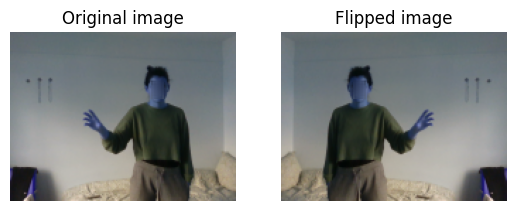

In [4]:
plt.subplot(1, 2, 1)
plt.title("Original image")
plt.axis('off')
plt.imshow(test_img)

flipped_vertically = cv2.flip(test_img, 1)

plt.subplot(1, 2, 2)
plt.title("Flipped image")
plt.axis('off')
plt.imshow(flipped_vertically)

plt.show

Helper functions to get some statistics about dataset while preprocessing

In [ ]:
def count_examples(dictionary):
    '''
    Count the number of examples in the dataset.

    Args:
        dictionary (dict): A dictionary containing the dataset.
    '''
    num_examples = 0
    for split in dictionary:
        for class_label in dictionary[split]:
            num_examples += len(dictionary[split][class_label])

    print(f"Number of examples in the extracted dataset: {num_examples}")

In [ ]:
def print_dictionary(dictionary):
    '''
    Print the contents of the dataset dictionary.

    Args:
        dictionary (dict): A dictionary containing the dataset.
    '''
    for split in dictionary:
        for class_label in dictionary[split]:
            for example in dictionary[split][class_label]:
                frames = dictionary[split][class_label][example]
                print(f"Split: {split}, Class: {class_label}, Example: {example}, Frames: {frames}")

This function was used to get half dataset in order to augmenting it by flipping all the frames

In [ ]:
import random

def extract_random_examples(dataset_path, percentage=0.5):
    '''
    Extract a random subset of examples from the dataset.
    
    Args:
        dataset_path (str): The path to the dataset directory.
        percentage (float): The percentage of examples to extract.

    Returns:
        dict: A dictionary containing the extracted examples.
    '''
    extracted_examples = defaultdict(lambda: defaultdict(dict))

    # loop over split directories
    for split in ["train", "test"]:
        split_path = os.path.join(dataset_path, split)

        # get class labels
        class_labels = [class_label for class_label in os.listdir(split_path) if not class_label.startswith('.')]
    
        for class_label in class_labels:
            class_path = os.path.join(split_path, class_label)
            
            examples = [example for example in os.listdir(class_path) if not example.startswith('.')]
            
            # Shuffle the examples
            random.shuffle(examples)
            
            # Calculate the number of examples to extract
            num_examples_to_extract = int(len(examples) * percentage)
            
            # Select the first 50% of the shuffled examples
            selected_examples = examples[:num_examples_to_extract]
            
            for example in selected_examples:
                example_path = os.path.join(class_path, example)
                extracted_examples[split][class_label][example] = example_path
    
    return extracted_examples


Number of examples in the original dataset: 4184
Number of examples in the extracted dataset: 2086
Split: train, Class: scroll_down, Example: 2021-10-16-130229_11, Frames: /Users/sebastianosanson/Development/VCS_Project/rgb_blur/train/scroll_down/2021-10-16-130229_11
Split: train, Class: scroll_down, Example: 2021-10-30-155255_2, Frames: /Users/sebastianosanson/Development/VCS_Project/rgb_blur/train/scroll_down/2021-10-30-155255_2
Split: train, Class: scroll_down, Example: 2021-10-29-204718_38, Frames: /Users/sebastianosanson/Development/VCS_Project/rgb_blur/train/scroll_down/2021-10-29-204718_38
Split: train, Class: scroll_down, Example: 2021-10-17-120228_11, Frames: /Users/sebastianosanson/Development/VCS_Project/rgb_blur/train/scroll_down/2021-10-17-120228_11
Split: train, Class: scroll_down, Example: 2021-10-30-171159_19, Frames: /Users/sebastianosanson/Development/VCS_Project/rgb_blur/train/scroll_down/2021-10-30-171159_19
Split: train, Class: scroll_down, Example: 2021-10-28-0953

Usage of the above function

In [ ]:
# extracted_examples = extract_random_examples(ORIGINAL_DATASET_PATH)

# count_examples(extracted_examples)

# print_dictionary(extracted_examples)

In [ ]:
def numerical_sort(file_list):
    '''
    Sort a list of files numerically.

    Args:
        file_list (list): A list of files.

    Returns:
        list: A list of files sorted numerically.
    '''
    return sorted(file_list, key=lambda x: int(os.path.splitext(x)[0]))

Then we have extracted every fourth frame from each example, as result we have 10 frames (before they were 40)

In [ ]:
# extracted_frames = defaultdict(lambda: defaultdict(dict))

# # Loop through the extracted examples
# for split in extracted_examples:
#     for class_label in extracted_examples[split]:
#         for example, example_path in extracted_examples[split][class_label].items():
#             # Get the list of frames in the example directory
#             frames = numerical_sort(os.listdir(example_path))
            
#             # Extract every fourth frame
#             selected_frames = frames[::4]
            
#             # Store the selected frames in the new dictionary
#             extracted_frames[split][class_label][example] = selected_frames

# count_examples(extracted_frames)

# print_dictionary(extracted_frames)

Number of examples in the extracted dataset: 2086
Split: train, Class: scroll_down, Example: 2021-10-16-130229_11, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: train, Class: scroll_down, Example: 2021-10-30-155255_2, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: train, Class: scroll_down, Example: 2021-10-29-204718_38, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: train, Class: scroll_down, Example: 2021-10-17-120228_11, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: train, Class: scroll_down, Example: 2021-10-30-171159_19, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: train, Class: scroll_down, Example: 2021-10-28-095350_17, Frames: ['0.png', '4.png', '8.p

This cell writes the augmented dataset 

In [ ]:
# # Writing the new dataset

# os.makedirs(AUGMENTED_DATASET_PATH, exist_ok=True)

# for split in extracted_frames:
#     split_path = os.path.join(AUGMENTED_DATASET_PATH, split)
#     os.makedirs(split_path, exist_ok=True)
    
#     for class_label in extracted_frames[split]:
#         class_path = os.path.join(split_path, class_label)
#         os.makedirs(class_path, exist_ok=True)

#         for example in extracted_frames[split][class_label]:
#             origin_path = os.path.join(AUGMENTED_DATASET_PATH, split, class_label, example)
#             os.makedirs(origin_path, exist_ok=True)
#             # print(origin_path)
#             flip_path = os.path.join(AUGMENTED_DATASET_PATH, split, class_label, f"{example}_flipped")
#             os.makedirs(flip_path, exist_ok=True)
#             # print(flip_path)
#             for frame in extracted_frames[split][class_label][example]: 
#                 frame_path = os.path.join(DATASET_PATH, split, class_label, example, frame)
#                 frame_img = cv2.imread(frame_path)
#                 cv2.imwrite(os.path.join(origin_path, frame), frame_img)
#                 flipped_img = cv2.flip(frame_img, 1)
#                 cv2.imwrite(os.path.join(flip_path, frame), flipped_img)

This cell get the augmented dataset, putting it into a dictionary

In [72]:
# get the rgb_blur_augmented dataset into a dictionary
augmented_dataset = defaultdict(lambda: defaultdict(dict))

splits = [split for split in os.listdir(AUGMENTED_DATASET_PATH) if not split.startswith('.')]
for split in splits:
    split_path = os.path.join(AUGMENTED_DATASET_PATH, split)
    class_labels = [class_label for class_label in os.listdir(split_path) if not class_label.startswith('.')]
    for class_label in class_labels:
        class_path = os.path.join(split_path, class_label)
        examples = [example for example in os.listdir(class_path) if not example.startswith('.')]
        for example in examples:
            example_path = os.path.join(class_path, example)
            frames = numerical_sort(os.listdir(example_path))
            augmented_dataset[split][class_label][example] = frames

count_examples(augmented_dataset)

print_dictionary(augmented_dataset)

Number of examples in the extracted dataset: 4172
Split: test, Class: scroll_down, Example: 2021-11-05-090018_23_flipped, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: test, Class: scroll_down, Example: 2021-11-05-084931_27_flipped, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: test, Class: scroll_down, Example: 2021-11-05-090012_21_flipped, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: test, Class: scroll_down, Example: 2021-11-05-084823_0, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: test, Class: scroll_down, Example: 2021-11-05-090020_24, Frames: ['0.png', '4.png', '8.png', '12.png', '16.png', '20.png', '24.png', '28.png', '32.png', '36.png']
Split: test, Class: scroll_down, Example: 2021-11-05-090007_19_flipped, Frame

## Dataset Preprocessing

In this section we will apply transformations to enhance the image and convert it into tensor, for features extraction

Downloading the pre-trained models to detect:
- [hands keypoints](https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker)

In [ ]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

- [pose keypoints](https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker)

In [1]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

zsh:1: command not found: wget


In [ ]:
# set the margin for the image cropping

MARGIN = 20  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # vibrant green

In [ ]:
def draw_pose_landmarks_on_image(image, detection_result):
  '''
  Draw the pose landmarks on the input image.

  Args:
      image (np.array): The input image.
      detection_result (mediapipe.python.solution_base.SolutionOutputs): The detection result.

  Returns:
      np.array: The annotated image.
      x_coordinates (list): The x-coordinates of the detected keypoints.
      y_coordinates (list): The y-coordinates of the detected keypoints.
  '''
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(image)
  x_coordinates = []
  y_coordinates = []

  # Check if any pose landmarks were detected
  if pose_landmarks_list:
    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
      pose_landmarks = pose_landmarks_list[idx]

      # Draw the pose landmarks.
      pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
      pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
      ])
      solutions.drawing_utils.draw_landmarks(
        annotated_image,
        pose_landmarks_proto,
        solutions.pose.POSE_CONNECTIONS,
        solutions.drawing_styles.get_default_pose_landmarks_style())

      # Get the coordinates of all the keypoints
      height, width, _ = annotated_image.shape
      x_coordinates += [int(landmark.x * width) for landmark in pose_landmarks]
      y_coordinates += [int(landmark.y * height) for landmark in pose_landmarks]

    return annotated_image, x_coordinates, y_coordinates
  else:
    # Return default values or handle the case when no landmarks are found
    return image, [], []  # Return original image and empty lists for x, y

In [ ]:
def draw_hand_landmarks_on_image(rgb_image, detection_result):
    '''
    Draw the hand landmarks on the input image.

    Args:
        rgb_image (np.array): The input image.
        detection_result (mediapipe.python.solution_base.SolutionOutputs): The detection result.

    Returns:
        np.array: The annotated image.
        x_coordinates (list): The x-coordinates of the detected keypoints.
        y_coordinates (list): The y-coordinates of the detected keypoints
    '''
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)
    x_coordinates = []
    y_coordinates = []

    # Loop through the detected hands to visualize
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style())

        # Get the coordinates of all the keypoints
        height, width, _ = annotated_image.shape
        x_coordinates += [int(landmark.x * width) for landmark in hand_landmarks]
        y_coordinates += [int(landmark.y * height) for landmark in hand_landmarks]

    return annotated_image, x_coordinates, y_coordinates

In [ ]:
def crop(image, x_coordinates, y_coordinates):
    '''
    Crop the input image around the detected hand landmarks.

    Args:
        image (np.array): The input image.
        x_coordinates (list): The x-coordinates of the detected keypoints.
        y_coordinates (list): The y-coordinates of the detected keypoints.

    Returns:
        np.array: The cropped image.
    '''

    height, width, _ = image.shape

    x_min = max(min(x_coordinates) - MARGIN, 0)
    x_max = min(max(x_coordinates) + MARGIN, width)
    y_min = max(min(y_coordinates) - MARGIN, 0)
    y_max = min(max(y_coordinates) + MARGIN, height)

    return image[y_min:y_max, x_min:x_max]

In [ ]:
def get_detector(hands=True):
    '''
    Get the hand or pose landmark detector.

    Args:
        hands (bool): Whether to use the hand landmark detector.

    Returns:
        mediapipe.python.solution_base.Solution: The hand or pose landmark detector
    '''
    if hands:
        base_options = python.BaseOptions(model_asset_path='/Users/sebastianosanson/Development/VCS_Project/task-model/hand_landmarker.task')
        options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
        detector = vision.HandLandmarker.create_from_options(options)
    else:
        base_options = python.BaseOptions(model_asset_path='/Users/sebastianosanson/Development/VCS_Project/task-model/pose_landmarker.task')
        options = vision.PoseLandmarkerOptions(base_options=base_options)
        detector = vision.PoseLandmarker.create_from_options(options)

    return detector

def get_coordinates_from(image_path,hands = True):
    '''
    Get the coordinates of the detected landmarks in the input image.

    Args:
        image_path (str): The path to the input image.
        hands (bool): Whether to detect hand landmarks.

    Returns:
        int: The x-coordinate of the detected landmarks.
        int: The y-coordinate of the detected landmarks
    '''
    detector = get_detector(hands)

    image = mp.Image.create_from_file(image_path)

    detection_result = detector.detect(image)

    if hands:
        annotated, x, y = draw_hand_landmarks_on_image(image.numpy_view(), detection_result)
    else:
        image_np = image.numpy_view()  

        if image_np.shape[-1] == 4:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)

        annotated, x, y = draw_pose_landmarks_on_image(image_np, detection_result)

    return x, y

def crop_image(image_path, hands = True):
    '''
    Crop the input image around the detected landmarks.

    Args:
        image_path (str): The path to the input image.
        hands (bool): Whether to detect hand landmarks.

    Returns:
        np.array: The cropped image.
    '''
    x, y = get_coordinates_from(image_path, hands)
    image = cv2.imread(image_path)

    if not x or not y:
        return None
    else:
        cropped_image = crop(image, x, y)
        return cropped_image

In [ ]:
def resize_image(cropped_image):
  '''
  Resize the input image to 75x75 pixels.

  Args:
      cropped_image (np.array): The input image.

  Returns:
      np.array: The resized image.
  '''
  image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

  resized_image = cv2.resize(image, (75, 75))

  resized_image = resized_image / 255.0

  return resized_image

In [ ]:
def img_to_tensor(image):
    '''
    Convert the input image to a tensor.

    Args:
        image (np.array): The input image.

    Returns:
        tf.Tensor: The image tensor
    '''
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    image_tensor = tf.expand_dims(image_tensor, axis=0)

    return image_tensor

In [ ]:
def sharpening_transformation(image):
  '''
  Apply a sharpening kernel to the input image.

  Args:
      image (np.array): The input image.

  Returns:
      np.array: The sharpened image.
  '''

  kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

  sharpened_image = cv2.filter2D(image, -1, kernel)

  return sharpened_image

In [ ]:
def clahe_transformation(resized_image):
    '''
    Apply the CLAHE transformation to the input image.

    Args:
        resized_image (np.array): The input image.

    Returns:
        np.array: The enhanced image
    '''
    lab = cv2.cvtColor(resized_image, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)

    enhanced = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)  # Convert back to RGB

    return enhanced

In [ ]:
def preprocess_data(frame_path):
    '''
    Preprocess the input frame.

    Args:
        frame_path (str): The path to the input frame.

    Returns:
        tf.Tensor: The preprocessed frame.
    '''
    # Detect and crop base on Region of Interest
    cropped = crop_image(frame_path, hands=False)
    # Resize the image to 75x75
    resized = resize_image(cropped)
    # Apply filters to enhance the image
    enhanced = clahe_transformation(resized)
    sharpened = sharpening_transformation(enhanced)
    denoised = cv2.bilateralFilter(sharpened, 9, 75, 75)
    # Convert the image to a tensor
    to_tensor = img_to_tensor(denoised)

    return to_tensor

This code cell runs all the transformations on a test image

Orginal image shape:(120, 160, 3)


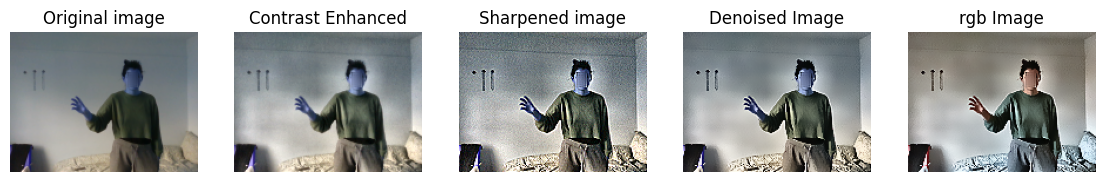

In [ ]:
plt.figure(figsize=(14, 6))  # Adjust figure size

plt.subplot(1, 7, 1)  # 1 row, 3 columns, first subplot
plt.title("Original image")
plt.axis('off')
plt.imshow(test_img)

print(f"Orginal image shape:{test_img.shape}")

cropped = crop_image(TEST_IMAGE_PATH, hands=False)

plt.subplot(1, 7, 2)  # 1 row, 3 columns, second subplot
plt.title("Cropped image")
plt.axis('off')
plt.imshow(cropped)

print(f"Cropped image shape:{cropped.shape}")

resized = resize_image(cropped)

plt.subplot(1, 7, 3)  # 1 row, 3 columns, third subplot
plt.title("Resized image")
plt.axis('off')
plt.imshow(resized)

print(f"Resized image shape:{resized.shape}")

enhanced = clahe_transformation(resized)

plt.subplot(1, 7, 4)
plt.title("Contrast Enhanced")
plt.axis('off')
plt.imshow(enhanced)

sharpened = sharpening_transformation(enhanced)

plt.subplot(1, 7, 5)  # 1 row, 3 columns, third subplot
plt.title("Sharpened image")
plt.axis('off')
plt.imshow(sharpened)

denoised = cv2.bilateralFilter(sharpened, 9, 75, 75)

plt.subplot(1, 7, 6)
plt.title("Denoised Image")
plt.axis('off')
plt.imshow(denoised)

# # reconvert to rgb
# to_rgb = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)

# plt.subplot(1, 7, 7)
# plt.title("rgb Image")
# plt.axis('off')
# plt.imshow(to_rgb)

plt.show()

### Prepocessing over dataset

The following loop apply the transformations chain: ROI detection, transformations and conversion to tensor

In [ ]:
preprocessed_data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

total_iterations = sum(
    len(os.listdir(os.path.join(AUGMENTED_DATASET_PATH, split, class_label)))
    for split in ["train", "test"]
    for class_label in os.listdir(os.path.join(AUGMENTED_DATASET_PATH, split)) if not class_label.startswith('.')
)

with tqdm(total=total_iterations, desc="Processing examples") as pbar:
  splits = [split for split in os.listdir(AUGMENTED_DATASET_PATH) if not split.startswith('.')]
  for split in splits:
      split_path = os.path.join(AUGMENTED_DATASET_PATH, split)
      class_labels = [class_label for class_label in os.listdir(split_path) if not class_label.startswith('.')]
      for class_label in class_labels:
          class_path = os.path.join(split_path, class_label)
          examples = [example for example in os.listdir(class_path) if not example.startswith('.')]
          for example in examples:
              example_path = os.path.join(class_path, example)
              frames = [frame for frame in os.listdir(example_path) if not frame.startswith('.')]
              for frame in frames:
                  frame_path = os.path.join(example_path, frame)
                  # frame_img = cv2.imread(frame_path)
                  tensor = preprocess_data(frame_path)
                  preprocessed_data[split][class_label][example].append(tensor)

              pbar.update(1)

This cell exports the tensors dictionary, replace the path with the actual one

In [ ]:
# Convert defaultdict to a normal dict
normal_dict = {k: dict(v) for k, v in preprocessed_data.items()}

# Save to a pickle file
with open("/Users/sebastianosanson/Development/VCS_Project/exported-data/pose-data/transformed_pose_data.pkl", "wb") as f:
    pickle.dump(normal_dict, f)

# Features extraction

In this section we will extract the features by using InceptionV3

Run this cell to get the exported file of the previous tensors dictionary:
- `preprocessed_data.pkl`, preprocessed data dictionary of hands ROI

In [ ]:
DATA_NAME = "preprocessed_data.pkl"

preprocessed_data_path = hf_hub_download(repo_id=REPO_ID, filename=DATA_NAME, repo_type="dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessed_data.pkl:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

Replace the path of preprocessed data to import the dictionary

In [ ]:
preprocessed_data_path = "/Users/sebastianosanson/Development/VCS_Project/exported-data/pose-data/transformed_pose_data.pkl"

# Load the dictionary back
with open(preprocessed_data_path, "rb") as f:
    preprocessed_data = pickle.load(f)

In [ ]:
def print_preprocessed_data(preprocessed_data):
    """Prints the preprocessed_data dictionary in a structured format."""
    
    for split, classes in preprocessed_data.items():
        print(f"\n Split: {split.upper()}")
        for class_label, examples in classes.items():
            print(f"  Class: {class_label}")
            for example, frames in examples.items():
                print(f"    Example: {example}")
                print(f"      Frames Processed ({len(frames)}):")
                for idx, frame in enumerate(frames):
                    print(f"        {idx+1}. Tensor Shape: {frame.shape}")  # Print tensor shape

In [ ]:
print_preprocessed_data(preprocessed_data)


 Split: TRAIN
  Class: scroll_down
    Example: 2021-11-05-084908_18
      Frames Processed (20):
        1. Tensor Shape: (1, 75, 75, 3)
        2. Tensor Shape: (1, 75, 75, 3)
        3. Tensor Shape: (1, 75, 75, 3)
        4. Tensor Shape: (1, 75, 75, 3)
        5. Tensor Shape: (1, 75, 75, 3)
        6. Tensor Shape: (1, 75, 75, 3)
        7. Tensor Shape: (1, 75, 75, 3)
        8. Tensor Shape: (1, 75, 75, 3)
        9. Tensor Shape: (1, 75, 75, 3)
        10. Tensor Shape: (1, 75, 75, 3)
        11. Tensor Shape: (1, 75, 75, 3)
        12. Tensor Shape: (1, 75, 75, 3)
        13. Tensor Shape: (1, 75, 75, 3)
        14. Tensor Shape: (1, 75, 75, 3)
        15. Tensor Shape: (1, 75, 75, 3)
        16. Tensor Shape: (1, 75, 75, 3)
        17. Tensor Shape: (1, 75, 75, 3)
        18. Tensor Shape: (1, 75, 75, 3)
        19. Tensor Shape: (1, 75, 75, 3)
        20. Tensor Shape: (1, 75, 75, 3)
    Example: 2021-11-05-084827_1
      Frames Processed (20):
        1. Tensor Shape: (1,

This cell initialise the InceptionV3 model to the extract the features

In [ ]:
# Define input shape
INPUT_SHAPE = (75, 75, 3)

base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
  )

# Extract features from the last convolutional layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
# features = feature_extractor.predict(image_tensor)
# print("Feature shape:", features.shape)

# Initialize dictionary to store extracted features
extracted_features = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))


Loop over the dataset to extract the features and save them into a dictionary

In [ ]:
# Extract features with progress tracking
total_frames = sum(len(examples) for classes in augmented_dataset.values()
                   for examples in classes.values())

with tqdm(total=total_frames, desc="Extracting Features") as pbar:
  for split, classes in augmented_dataset.items():
      for class_label, examples in classes.items():
          for example, frames in examples.items():
            for frame in frames:
              features = feature_extractor.predict(frame, verbose=0)
              extracted_features[split][class_label][example].append(features)

            pbar.update(1)


# Check model summary
feature_extractor.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_376 (Conv2D) │ (None, None,      │        864 │ input_layer_4[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_376[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_376      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_377 (Conv2D) │ (None, None,      │      9,216 │ activation_376[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_377[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_377      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_378 (Conv2D) │ (None, None,      │     18,432 │ activation_377[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_378[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_378      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, None,      │          0 │ activation_378[0… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_379 (Conv2D) │ (None, None,      │      5,120 │ max_pooling2d_16… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_379[0][0]  │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_379      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_380 (Conv2D) │ (None, None,      │    138,240 │ activation_379[0… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_380[0][0]  │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_380      │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

Run this cell to export the dictionary of extracted features, replace the destination path

In [80]:
# Convert defaultdict to a normal dict
normal_dict = {k: dict(v) for k, v in extracted_features.items()}

# Save to a pickle file
with open("/Users/sebastianosanson/Development/VCS_Project/exported-data/pose-data/new_pose_extracted_features.pkl", "wb") as f:
    pickle.dump(normal_dict, f)

# LSTM

In this section we finally train the LSTM over the features extracted

If you do not have the features, download by running this cell.
There are some choices:
- `extracted_feature.pkl`, dictionary with features on hands ROI
- `pose_extracted_feature.pkl`, dictionary with features on pose ROI
- `transformed_pose_extracted_feature.pkl`, dictionary with features on hands ROI with the chain of transformation to enhance the image after the resizing

In [ ]:
FEATURES_NAME = "extracted_features.pkl"
features_path = hf_hub_download(repo_id=REPO_ID, filename=FEATURES_NAME, repo_type="dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


extracted_features.pkl:   0%|          | 0.00/275M [00:00<?, ?B/s]

When downloaded the file, run this cell to import it into a dictionary

In [102]:
preprocessed_data_path = "/Users/sebastianosanson/Development/VCS_Project/exported-data/pose-data/transformed_pose_extracted_features.pkl"

# Load the dictionary back
with open(preprocessed_data_path, "rb") as f:
    features_data  = pickle.load(f)

Runn this instead if you already have the dictionary with extracted features

In [82]:
features_data = extracted_features

In [ ]:
# Get unique class labels
unique_labels = sorted(set(class_label for split in features_data.keys() for class_label in features_data[split].keys()))

# Dictionary mapping class labels (strings) to integer values
label_map = {label: idx for idx, label in enumerate(unique_labels)}

print("Label Mapping:", label_map)

Label Mapping: {'scroll_down': 0, 'scroll_left': 1, 'scroll_right': 2, 'scroll_up': 3, 'zoom_in': 4, 'zoom_out': 5}


Preparing the *training* data for LSTM: filtering the examples by getting only the ones with exactly 10 frames

In [ ]:
X = []
y = []

MAX_FRAMES = 10

for split in ["train"]:  
    for class_label in features_data[split].keys():
        for example, features in features_data[split][class_label].items():
          if len(features) == MAX_FRAMES:
            X.append(features)  
            y.append(label_map[class_label])  

X = np.array(X, dtype="float32")  
X = X.reshape(X.shape[0], X.shape[1], -1)
y = np.array(y)  

# Ensure shape is (num_samples, sequence_length, 2048)
print("Feature Shape:", X.shape)  

# One-hot encode labels for classification
num_classes = len(label_map)
y = keras.utils.to_categorical(y, num_classes)

Feature Shape: (3752, 10, 2048)


Running the LSTM training

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(2048,
                            activation='tanh',
                            dropout=0.3,
                            recurrent_activation='sigmoid',
                            recurrent_dropout=0.3,
                            kernel_regularizer=keras.regularizers.l2(1e-3),
                            input_shape=(X.shape[1], 2048)))

model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3)))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),

    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # min_delta= 0.5,
    patience=10,  
    restore_best_weights=True  
)

history = model.fit(
    X,
    y,
    epochs=300,
    batch_size=64,
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stopping]  
)

/Users/sebastianosanson/Development/VCS_Project/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3886 - loss: 5.5176 - val_accuracy: 0.7269 - val_loss: 4.3143
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7870 - loss: 4.0910 - val_accuracy: 0.8889 - val_loss: 3.4393
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8722 - loss: 3.4062 - val_accuracy: 0.9076 - val_loss: 3.0200
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9235 - loss: 2.9560 - val_accuracy: 0.9130 - val_loss: 2.7366
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9393 - loss: 2.6606 - val_accuracy: 0.9438 - val_loss: 2.5152
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9578 - loss: 2.4235 - val_accuracy: 0.9357 - val_loss: 2.3430
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9762 - loss: 2.2410 - val_accuracy: 0.9277 - val_loss: 2.2211
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9719 - loss: 2.1131 - val_accuracy: 0.9438 - val_loss:

Preparing the *test* data for LSTM: filtering the examples by getting only the ones with exactly 10 frames

In [ ]:
X_test = []
y_test = []

for class_label in features_data['test'].keys():
        for example, features in features_data['test'][class_label].items():
          if len(features) == MAX_FRAMES:
            X_test.append(features)  
            y_test.append(label_map[class_label])  

X_test = np.array(X_test, dtype="float32") 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
y_test = np.array(y_test)  

print("Feature Shape:", y_test.shape)

Feature Shape: (420,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print("y_test shape (before):", y_test.shape)  # (num_samples,)
print("y_test shape (after):", y_test_one_hot.shape)  # (num_samples, 6)

y_test shape (before): (113,)
y_test shape (after): (113, 6)


Running model evaluation on test data

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.9059 - loss: 0.2547
Test Loss: 0.2756
Test Accuracy: 0.9027


# Exporting model

Converting the model to .tflite and export it, replace the destination path

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  
converter.experimental_enable_resource_variables = True
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Convert to TFLite model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = "/content/saved_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")

Saved artifact at '/tmp/tmpcey0izxr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 2048), dtype=tf.float32, name='keras_tensor_643')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  131922479355024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479356560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479354832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479358480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479353680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479357136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131922479353104: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved to: /content/saved_model.tflite
